In [1]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("mnist-1.csv", header=None)

# Separate labels and images
labels = data.iloc[:, 0].values
images = data.iloc[:, 1:].values.astype(float)

In [2]:
# Standardize the data
mean = np.mean(images, axis=0)
X_c = images - mean
    
# Compute the covariance matrix
n = X_c.shape[0]
C_X = np.cov(X_c, rowvar=False)
    
# Compute eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(C_X)
    
# Sort eigenvalues and eigenvectors in descending order
index = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[index]
sorted_eigenvectors = eigenvectors[:, index]
    
# Select the top n_components eigenvectors
P = sorted_eigenvectors[:, :10]
    
# Project the data to the new space
Y = np.dot(X_c, P)

# Compute the covariance matrix of the transformed data
cov_matrix = np.cov(Y, rowvar=False)

# Print the covariance matrix
print(cov_matrix)

[[ 5.30558677e+00 -2.34518189e-16  1.69374248e-15 -1.45863207e-15
   1.10389370e-15  4.79696296e-16 -2.12606136e-16 -5.49577979e-16
   6.97040173e-16 -7.10661179e-17]
 [-2.34518189e-16  3.87701635e+00  2.47902308e-15 -5.94586520e-16
  -1.56996899e-15  9.54654851e-16 -2.43993672e-16 -2.13198354e-17
  -9.68275857e-16  6.39595061e-17]
 [ 1.69374248e-15  2.47902308e-15  3.28704664e+00  1.01861436e-16
  -2.55838025e-16 -7.03554567e-16  8.46871239e-16  8.67006639e-16
  -3.57699460e-16 -4.07445743e-16]
 [-1.45863207e-15 -5.94586520e-16  1.01861436e-16  2.91254096e+00
  -6.39595061e-16  3.77242643e-16  1.30287883e-16 -7.30796579e-16
   5.99324261e-16 -2.92851628e-16]
 [ 1.10389370e-15 -1.56996899e-15 -2.55838025e-16 -6.39595061e-16
   2.48633206e+00 -2.16159442e-15  3.43486237e-17 -2.51100283e-16
   6.89933562e-17 -1.36210059e-16]
 [ 4.79696296e-16  9.54654851e-16 -7.03554567e-16  3.77242643e-16
  -2.16159442e-15  2.35358942e+00  1.03874976e-15  2.32859980e-15
  -7.53300850e-16 -1.16074659e-16

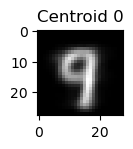

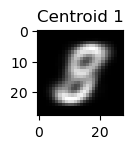

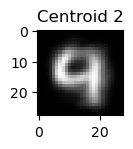

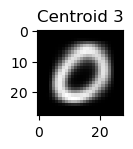

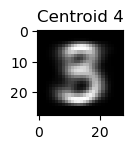

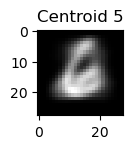

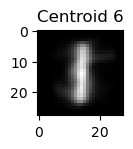

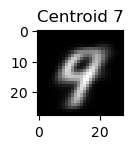

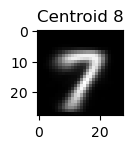

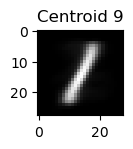

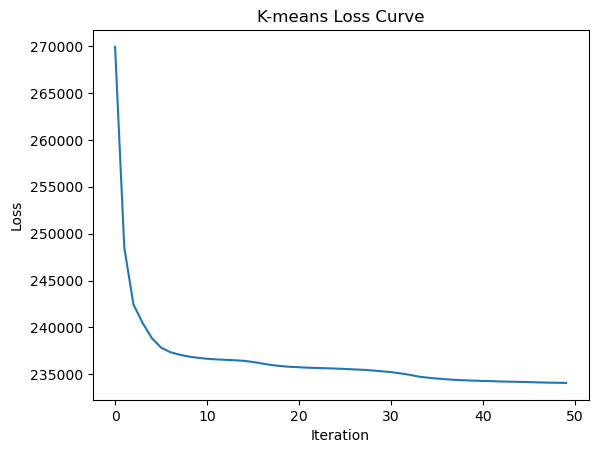

In [9]:
import matplotlib.pyplot as plt

K = 10

# Select K data points as initial centroids
centroids = images[np.random.choice(images.shape[0], K, replace=False)]
prev_centroids = centroids.copy()
k_labels = np.zeros(images.shape[0])
losses = []  # List to store loss at each iteration

for iter in range(50):
    # E-step: Assign each data point to the nearest centroid
    for i, image in enumerate(images):
        distances = np.linalg.norm(image - centroids, axis=1)
        k_labels[i] = np.argmin(distances)

    # M-step: Compute the new centroids from the clusters
    centroids = np.array([images[k_labels == i].mean(axis=0) for i in range(K)])
    # Check for convergence
    if np.all(prev_centroids == centroids):
        break

    # Compute the loss (sum of squared distances)
    loss = np.sum([np.linalg.norm(images[k_labels == i] - centroids[i])**2 for i in range(K)])
    losses.append(loss)
    prev_centroids = centroids.copy()

k_labels = k_labels.astype(int)

for i, centroid in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid.reshape(28, 28), cmap='gray')
    plt.title(f'Centroid {i}')
    plt.show()

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('K-means Loss Curve')
plt.show()

Best number of clusters based on validation set: 10


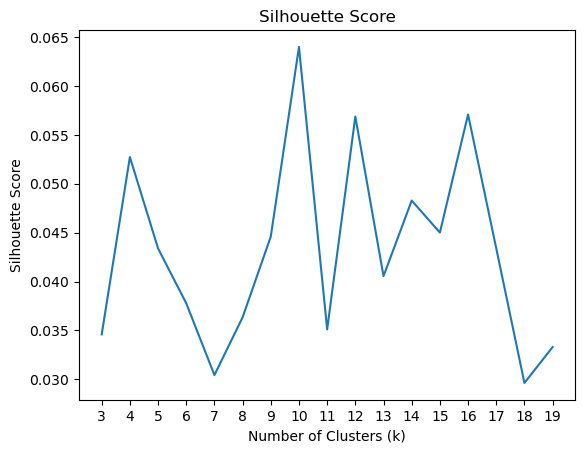

In [5]:
from sklearn.metrics import silhouette_score

# Split the data
train_data = images[:4000]
valid_data = images[4000:]
def kmeans_initialization(X, K):
    # First centroid is chosen uniformly at random from the data points
    centroids = [X[np.random.choice(X.shape[0])]]
    for _ in range(1, K):
        dist_sq = np.array([min([np.dot(c-x,c-x) for c in centroids]) for x in X])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        centroids.append(X[i])
    return np.array(centroids)

def kmeans(X, K, n=50):
    centroids = kmeans_initialization(X, K)
    prev_centroids = centroids.copy()
    labels = np.zeros(X.shape[0])

    for _ in range(n):
        # E-step: Assign each data point to the nearest centroid
        for i, image in enumerate(X):
            distances = np.linalg.norm(image - centroids, axis=1)
            labels[i] = np.argmin(distances)

        # M-step: Compute the new centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(K)])
        
        # Check for convergence
        if np.all(prev_centroids == new_centroids):
            break

        prev_centroids = new_centroids.copy()

    return labels, centroids

K_range = list(range(3, 20))
silhouette_scores = []

for K in K_range:
    # Fit the KMeans model on the training data
    train_labels, train_centroids = kmeans(train_data, K)
    
    # Predict the labels for the validation data
    valid_labels, _ = kmeans(valid_data, K, n=1)  # Initialize using trained centroids
    
    # Compute the silhouette score on the validation data
    silhouette_avg = silhouette_score(valid_data, valid_labels)
    silhouette_scores.append(silhouette_avg)

best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best number of clusters based on validation set: {best_k}")

plt.plot(K_range, silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.xticks(K_range)
plt.show()


102.0119416195002


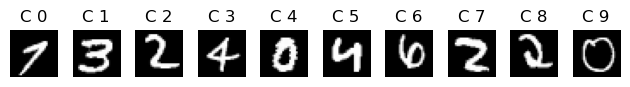

In [7]:
def rbf_kernel(X, sig2):
    N = X.shape[0]
    dis = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    K = np.exp(-dis / (sig2))
    return K

def kernel_kmeans(X, K, max_iters=1000):
    N = X.shape[0]
    sig2 = 1.0 / (N**2) * np.sum(np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)**2)
    print(sig2)
    
    # Calculate the RBF Kernel matrix
    kernel_matrix = rbf_kernel(X, sig2)

    # Initialize labels
    labels = np.random.randint(0, K, size=N)
    prev_labels = np.zeros(N)
    
    for it in range(max_iters):
        # Compute matrix M to avoid inner loops
        M = np.zeros((N, N))
        for k in range(K):
            nk = np.sum(labels == k)
            if nk == 0:
                continue
            mk = np.sum(kernel_matrix[:, labels == k], axis=1) / nk
            M[:, k] = mk
            
        # Update labels
        k_sum = np.zeros((N, K))
        for k in range(K):
            indices = labels == k
            nk = np.sum(indices)
            if nk == 0:  # Empty cluster
                continue
            
            k_sum[:, k] = np.sum(kernel_matrix[:, indices], axis=1) / nk

        sums = np.array([np.sum(kernel_matrix[labels == k][:, labels == k]) for k in range(K)]) / np.bincount(labels, minlength=K)**2
        dist = np.diag(kernel_matrix)[:, np.newaxis] - 2 * k_sum + sums
        labels = np.argmin(dist, axis=1)
        
        # Check for convergence
        if np.all(labels == prev_labels):
            break
        prev_labels = labels.copy()

    # Find and plot the center of each cluster
    for k in range(K):
        members_idx = np.where(labels == k)[0]
        average_distance = kernel_matrix[members_idx][:, members_idx].sum(axis=1)
        center_idx = members_idx[np.argmin(average_distance)]
        center_image = X[center_idx]
        
        plt.subplot(1, K, k + 1)
        plt.imshow(center_image.reshape(28, 28), cmap='gray')
        plt.title(f'C {k}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return labels

# Sample data
samples = images[:500]

# Perform Kernel K-means clustering
KK_labels = kernel_kmeans(samples, 10)